In [1]:
from __future__ import print_function
import sys
import os
import pandas as pd
import csv
import seaborn as sns
import time
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl") # remove warning from mac
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook" 
from IPython.display import display, HTML, Markdown
display(HTML("<style>:root { --jp-notebook-max-width: 80% !important; }</style>"))
from sklearn.utils._openmp_helpers import _openmp_effective_n_threads, _openmp_parallelism_enabled
_openmp_effective_n_threads(6)

plt.rcParams['pdf.fonttype'] = 42 

os.environ.setdefault("TF_NUM_THREADS", "10")
os.environ.setdefault("TF_LOOP_PARALLEL_ITERATIONS", "10")



import plotly
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import scipy
from scipy.spatial import distance
from scipy.cluster import hierarchy
import sklearn
from sklearn.metrics import silhouette_score
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph

np.random.seed(12345)

In [2]:
import plotly

colorway=["#B80000", "#E81E63", "#8D239E", "#673AB7", "#3F51B5", "#253985", "#02A8F4", "#009688", "#8BC34A", "#FF9800", "#FE5622", "#795648", "#9E9E9E", "#617D8B",]

plotly.io.templates["alphastats_colors"] = plotly.graph_objects.layout.Template(
    layout=plotly.graph_objects.Layout(
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
        colorway=colorway
        ,
    )
)
plotly.io.templates.default = "simple_white+alphastats_colors"

display(Markdown('<br>'.join(
    f'<span style="font-family: monospace">{color} <span style="color: {color}">████████</span></span>'
    for color in colorway
)))
len(colorway)

<span style="font-family: monospace">#B80000 <span style="color: #B80000">████████</span></span><br><span style="font-family: monospace">#E81E63 <span style="color: #E81E63">████████</span></span><br><span style="font-family: monospace">#8D239E <span style="color: #8D239E">████████</span></span><br><span style="font-family: monospace">#673AB7 <span style="color: #673AB7">████████</span></span><br><span style="font-family: monospace">#3F51B5 <span style="color: #3F51B5">████████</span></span><br><span style="font-family: monospace">#253985 <span style="color: #253985">████████</span></span><br><span style="font-family: monospace">#02A8F4 <span style="color: #02A8F4">████████</span></span><br><span style="font-family: monospace">#009688 <span style="color: #009688">████████</span></span><br><span style="font-family: monospace">#8BC34A <span style="color: #8BC34A">████████</span></span><br><span style="font-family: monospace">#FF9800 <span style="color: #FF9800">████████</span></span><br><span style="font-family: monospace">#FE5622 <span style="color: #FE5622">████████</span></span><br><span style="font-family: monospace">#795648 <span style="color: #795648">████████</span></span><br><span style="font-family: monospace">#9E9E9E <span style="color: #9E9E9E">████████</span></span><br><span style="font-family: monospace">#617D8B <span style="color: #617D8B">████████</span></span>

14

In [5]:
df = pd.read_csv('MeansDEGSvstSC_annotated.csv',low_memory=False)
df = df.set_index('gene_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3981 entries, ENSG00000001084 to ENSG00000285991
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HEK293T_untr          3981 non-null   float64
 1   HEK293T_EGFP          3981 non-null   float64
 2   HEK293T_WT            3981 non-null   float64
 3   HEK293T_KS            3981 non-null   float64
 4   HEK293T_KSFtoG        3981 non-null   float64
 5   gene_name             3963 non-null   object 
 6   description           3981 non-null   object 
 7   seq_name              3981 non-null   object 
 8   gene_seq_start        3981 non-null   int64  
 9   gene_seq_end          3981 non-null   int64  
 10  seq_strand            3981 non-null   int64  
 11  gene_id_version       3981 non-null   object 
 12  canonical_transcript  3981 non-null   object 
 13  gene_biotype          3981 non-null   object 
dtypes: float64(5), int64(3), object(6)
memory usage: 466

In [4]:
def search(regex: str, df, case=False):
    """Search all the text columns of `df`, return rows with any matches."""
    textlikes = df.select_dtypes(include=[object, "string"])
    return df[
        textlikes.apply(
            lambda column: column.str.contains(regex, regex=True, case=case, na=False)
        ).any(axis=1)
    ]

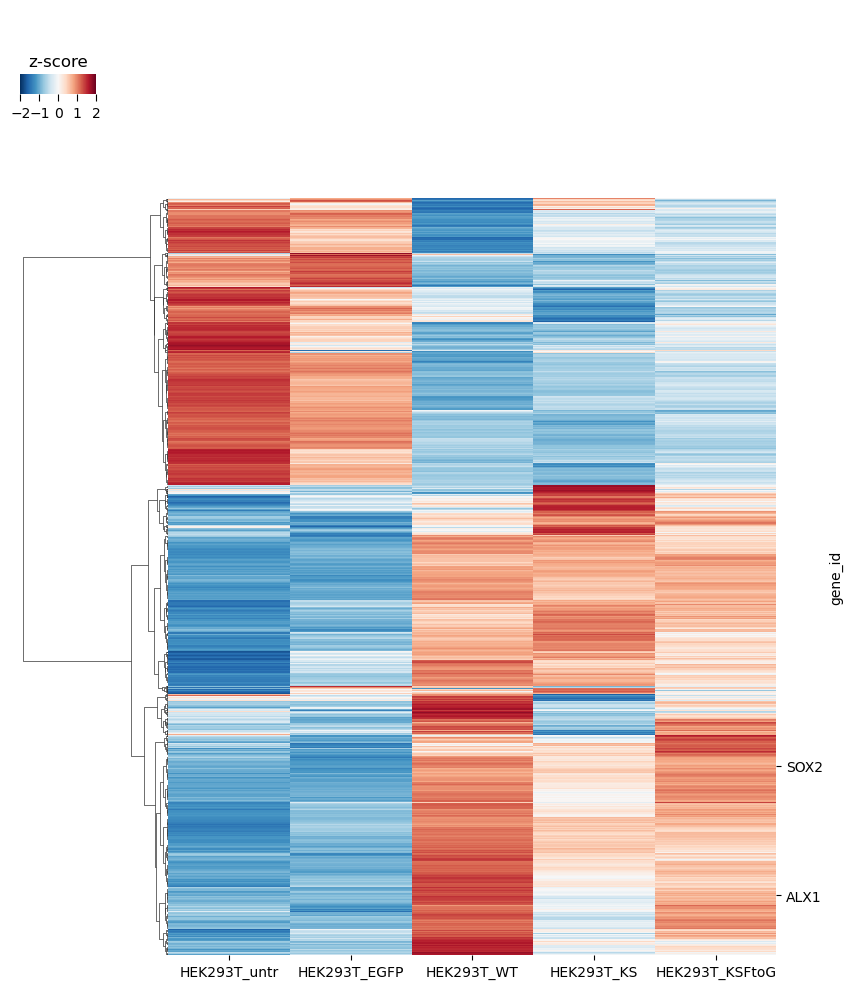

In [13]:
heat_clust = sns.clustermap(df.iloc[:, 0:5],
                            col_cluster=False,
                            yticklabels=False,
                            method='ward',
                            #cmap="rocket",
                            #row_colors=row_colors,
                            # cmap="coolwarm",
                            #cmap="icefire",
                            #cmap="RdPu",
                            #cmap="mako",
                            #cmap="YlGnBu",
                            #cmap=sns.diverging_palette(220, 20, as_cmap=True),
                            #cmap="RdYlBu",
                            cmap = 'RdBu_r',
                            center=0,
                            #mask=(ordered_df==0),
                            vmin=-2,
                            vmax=2,
                            cbar_kws=dict(
                                #ticks=[0,0.5, 1],
                                ticks=[-2, -1, 0, 1, 2],
                                orientation="horizontal",
                                
                            )
                           )

x0, _y0, _w, _h = heat_clust.cbar_pos
heat_clust.ax_cbar.set_position([x0,
                                 0.9,
                                 heat_clust.ax_row_dendrogram.get_position().width/2,
                                 0.02]
                               )
heat_clust.ax_cbar.set_title('z-score')
heat_clust.ax_cbar.tick_params(axis='x',
                               length=5)


reordered_labels = df.index[heat_clust.dendrogram_row.reordered_ind].tolist()
use_labels = []

# CREBBP = ["CREBBP"]

qPCR_genes = ["SOX2", "ALX1"]


# use_labels = pos_reg_trnscrpt_POLII

# use_labels = aa_imprt_pm
# use_labels = cell_fate_commitment

# use_labels = pos_reg_G2M_cellcycle
use_labels = qPCR_genes

use_labels_correct = []
use_labels_g = []
use_labels_c = []
for labels in use_labels:
    use_labels_correct.append(search(labels, df, case=False).index.values[0])

for labels in use_labels_correct:
    if labels in reordered_labels:
        use_labels_c.append(labels)
        use_labels_g.append(df.loc[[labels], "gene_name"].values[0])
    else: continue


use_ticks = [reordered_labels.index(label) + .5 for label in use_labels_c]

heat_clust.ax_heatmap.set(yticks=use_ticks, yticklabels=use_labels_g)

heat_clust.fig.set_size_inches((8,10))
heat_clust.savefig("Heatmap_clustered_filtered_svd_qualite_qPCR_genes.pdf", format = 'pdf')
# heat_clust.savefig("Heatmap_clustered_filtered_svd_qualite_polimerase.png", format = 'png', dpi = 300)

In [9]:
labels = heat_clust.ax_heatmap.yaxis.get_majorticklabels()
ordered_row_df_heat = heat_clust.data2d
row_order = heat_clust.data2d.index

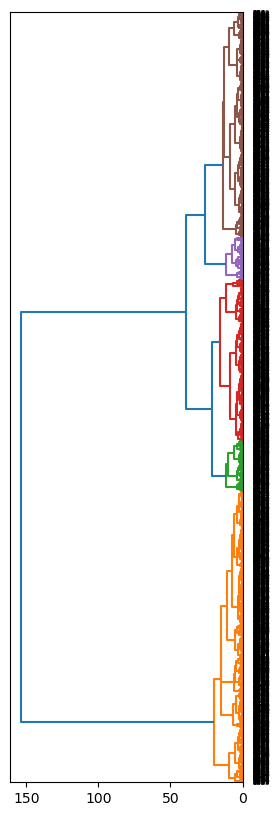

In [16]:
plt.figure(figsize=(3,10))
den = scipy.cluster.hierarchy.dendrogram(heat_clust.dendrogram_row.linkage,
                                         #labels = list(heat_clust.data2d.index),
                                         orientation='left',
                                         color_threshold = 20,
                                         get_leaves = True
                                         )
plt.savefig('den_Heatmap_clustered_filtered_svd_qualite.png', format='png', bbox_inches='tight')
plt.savefig('den_Heatmap_clustered_filtered_svd_qualite.pdf', format='pdf', bbox_inches='tight')

In [17]:
ordered_row_df = heat_clust.data2d
#extract ivl list (order of the dendrogram), leaves_color_list (cluster)
ordered_row_df.insert(0 , "cluster", den["leaves_color_list"])
ordered_row_df.insert(1 ,'order', np.arange(len(df)))
ordered_row_df.insert(2 , "original_index", den["ivl"])
ordered_row_df.head()

,cluster,order,original_index,HEK293T_untr,HEK293T_EGFP,HEK293T_WT,HEK293T_KS,HEK293T_KSFtoG
gene_id,,,,,,,,
ENSG00000172638,C1,0,2823,-0.150406,0.759768,-1.552707,0.993344,-0.049998
ENSG00000140993,C1,1,1687,0.253407,0.946808,-1.400439,0.827458,-0.627234
ENSG00000160961,C1,2,2261,0.161514,0.976387,-1.360381,0.867943,-0.645463
ENSG00000178951,C1,3,3051,0.253329,0.608829,-1.512008,1.055620,-0.405770
ENSG00000244274,C1,4,3852,0.348199,0.790582,-1.573263,0.802132,-0.367649


In [18]:
ordered_row_df.to_csv('ordered_row_df.csv', index=True)